In [1]:
from training_util import * 
from ImportsAndDatasets import *

/home/u111169/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/u111169/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
print("Imports completed")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Imports completed


In [3]:
df = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/DrugApp/All_training_feature_vectors.csv")
df["SMILES"] = df["SMILES"].apply(lambda x: get_canonical_smiles(x))
df.rename(columns={"Label":"labels"}, inplace=True)

In [4]:
train_df , val_df , test_df , dataset_train , dataset_df , dataset_test= train_valid_test_split(df[["SMILES" , "labels"]])

In [5]:
val_df.to_csv("val_df.csv" , index=False)

In [103]:
tokenizer = RobertaTokenizer.from_pretrained("/home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca")#'FacebookAI/xlm-roberta-large'
model = RobertaForSequenceClassification.from_pretrained("/home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca" ,num_labels=2)

model.config.classifier_dropout=0.01

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /home/u111169/.cache/huggingface/hub/models--DeepChem--ChemBERTa-77M-MTR/snapshots/66b895cab8adebea0cb59a8effa66b2020f204ca and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [61]:
def tokenize_function(examples):
    return tokenizer(examples['SMILES'], padding="max_length" , truncation=True )#,max_length=166

tokenized_train = dataset_train.map(tokenize_function)
tokenized_val = dataset_df.map(tokenize_function)
tokenized_test = dataset_test.map(tokenize_function)

Map:   0%|          | 0/2497 [00:00<?, ? examples/s]

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

In [8]:
class_weights = torch.tensor([len(train_df[train_df["labels"] == i]) / len(train_df) for i in np.unique(train_df["labels"])]).to(device)

In [9]:
class CustomLoss(nn.Module):
    def __init__(self, class_weights):
        super(CustomLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, logits, labels):
        ce_loss = self.ce_loss(logits, labels)
        l1_loss = torch.mean(torch.abs(logits))
        return ce_loss + 0.1 * l1_loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels", None)
        if labels is not None:
            labels = labels.to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Use Focal Loss
        if self.focal_loss:
            loss = self.loss_fn(logits, labels)
        else:
            loss = self.loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [10]:
torch.manual_seed(42)
np.random.seed(42)
import random
random.seed(42)

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduce=True):
        """
        Focal Loss implementation
        :param alpha: Weighting factor for class imbalance
        :param gamma: Focusing parameter (default is 2)
        :param reduce: Whether to average the loss across all examples
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Balancing factor for class imbalance
        self.gamma = gamma  # Focusing parameter
        self.reduce = reduce  # Whether to reduce the loss to a scalar or not

    def forward(self, inputs, targets):
        """
        :param inputs: Model predictions (logits, before softmax)
        :param targets: Ground truth labels
        """
        # Apply softmax to the logits to get probabilities
        inputs = F.softmax(inputs, dim=-1)

        # Get the probabilities for the true classes (targets)
        pt = inputs.gather(dim=-1, index=targets.unsqueeze(-1))
        
        # Compute the focal loss
        loss = -self.alpha * (1 - pt) ** self.gamma * torch.log(pt)
        
        # Reduce the loss across the batch (default: average over batch)
        if self.reduce:
            return loss.mean()
        else:
            return loss



In [11]:
# training_args = TrainingArguments(
#     output_dir='"/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/overfitted',
#     num_train_epochs= 4,
#     evaluation_strategy='steps',
#     save_strategy='steps',
#     learning_rate=0.0003781551408432445,
#     per_device_train_batch_size=128,
#     per_device_eval_batch_size=128,
#     save_steps=10,
#     eval_steps=1,
#     # save_total_limit=20,
#     gradient_accumulation_steps=1,
#     eval_accumulation_steps=1,
#     do_eval=True,
#     do_train=True,
#     weight_decay=0.1673670699490699,
#     logging_dir = '/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/overfitted/logs',
#     logging_strategy="steps",
#     logging_steps = 1,
#     dataloader_drop_last=True,
#     save_safetensors=False,
#     adam_epsilon=1e-08,
#     warmup_steps=0,
#     seed=42,
#     lr_scheduler_type='linear',
#     load_best_model_at_end = True,
#     label_smoothing_factor=0.01,
#     report_to = "none"
# )

/home/u111169/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=tokenized_train,
#     eval_dataset=tokenized_val,
#     tokenizer = tokenizer,
#     # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
# )
# trainer.train()#resume_from_checkpoint = True

In [104]:
config = {
    "learning_rate": 0.00007863425189001924,
    "lr_scheduler_type": "constant_with_warmup",
    "num_train_epochs": 5,
    "per_device_train_batch_size": 128,
    "warmup_steps": 50,
    "weight_decay": 0.2196608747070169
}

In [105]:
def compute_metrics(p):
    # Predicted class labels
    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids

    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    recall = recall_score(labels, preds)

    # Calculate confusion matrix for specificity (TN / (TN + FP))
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    # AUC calculation (binary classification assumed)
    auc = roc_auc_score(labels, p.predictions[:, 1]) if len(set(labels)) > 1 else 0.5  # Handle binary case

    return {
        "eval_accuracy": accuracy,
        "eval_f1": f1,
        "eval_recall": recall,
        "eval_specificity": specificity,
        "eval_auc": auc
    }

In [ ]:
args = TrainingArguments(
    output_dir="/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/overcos_e/",
    evaluation_strategy='steps',
    save_strategy='steps',
    # save_total_limit=5,
    learning_rate=config['learning_rate'],
    per_device_train_batch_size=config['per_device_train_batch_size'],
    weight_decay=config['weight_decay'],
    num_train_epochs=config['num_train_epochs'],
    warmup_steps=config['warmup_steps'],
    lr_scheduler_type=config['lr_scheduler_type'],
    logging_dir="/home/u111169/tune_logs",
    logging_steps=1,
    seed=42,
    report_to="mlflow", 
    save_steps=10,
    eval_steps=1,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/home/u111169/.local/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_64179/1767422377.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [107]:
trainer.train()  # Start training

Step,Training Loss,Validation Loss,Accuracy,F1,Recall,Specificity,Auc
1,0.695700,0.697224,0.428115,0.405316,0.305000,0.646018,0.444690
2,0.694900,0.697112,0.424920,0.403974,0.305000,0.637168,0.445398
3,0.692400,0.696893,0.428115,0.409241,0.310000,0.637168,0.446018
4,0.696900,0.696588,0.431310,0.422078,0.325000,0.619469,0.446770
5,0.692600,0.696198,0.444089,0.442308,0.345000,0.619469,0.447699
6,0.697500,0.695730,0.444089,0.456250,0.365000,0.584071,0.449159
7,0.693200,0.695177,0.447284,0.474164,0.390000,0.548673,0.450752
8,0.693500,0.694499,0.456869,0.494048,0.415000,0.530973,0.453584
9,0.692800,0.693734,0.469649,0.522989,0.455000,0.495575,0.455442
10,0.692700,0.692886,0.495208,0.563536,0.510000,0.469027,0.459779


TrainOutput(global_step=100, training_loss=0.6533690148591995, metrics={'train_runtime': 78.3462, 'train_samples_per_second': 159.357, 'train_steps_per_second': 1.276, 'total_flos': 115048949790720.0, 'train_loss': 0.6533690148591995, 'epoch': 5.0})

In [108]:
eval_result = trainer.evaluate()

In [109]:
eval_result

{'eval_accuracy': 0.6549520766773163,
 'eval_f1': 0.784,
 'eval_recall': 0.98,
 'eval_specificity': 0.07964601769911504,
 'eval_auc': 0.6510619469026548,
 'eval_loss': 0.6236522793769836,
 'eval_runtime': 0.4503,
 'eval_samples_per_second': 695.142,
 'eval_steps_per_second': 88.836,
 'epoch': 5.0}

In [114]:
# path = "/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/over/checkpoint-70"
# path = "/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/checkpoint-60"
# path = "/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/overfitted/checkpoint-60"
path = "/home/u111169/wrkdir/mgh-project/checkpoints/fine_tuning_chemberta_final_chemapp_dataset/overcos_e/checkpoint-80"

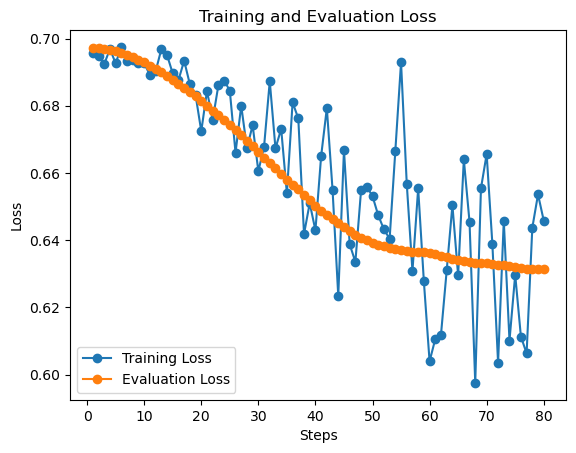

In [115]:
from evaluate_chemberta import *
plot_training_loss(f"{path}/trainer_state.json", 1)

In [116]:
model_path = f"{path}"
y_true, y_pred = evaluate_model(model_path, tokenized_val)
evaluate(y_true ,y_pred )

Map:   0%|          | 0/313 [00:00<?, ? examples/s]

{'F1 score': 0.7740667976424361,
 'Accuracy': 0.6325878594249201,
 'Precision': 0.6375404530744336,
 'Recall': 0.985,
 'AUC': 0.49692477876106195,
 'Specificity': 0.008849557522123894}

In [117]:
model_path = f"{path}"
y_true, y_pred = evaluate_model(model_path, tokenized_test)
evaluate(y_true ,y_pred )

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

{'F1 score': 0.7810650887573964,
 'Accuracy': 0.6442307692307693,
 'Precision': 0.6428571428571429,
 'Recall': 0.9949748743718593,
 'AUC': 0.5107617734691156,
 'Specificity': 0.02654867256637168}

In [118]:
external_d = [
    "Ogsiveo",
    "Agamree",
    "Velsipity",
    "Exxua",
    "Litfulo",
    "Miebo",
    "Veozah",
    "Daybue",
    "Zavzpret",
    "Filspari",
    "Orserdu",
    "Fabhalta",
    "Truqap",
    "Augtyro",
    "Vanflyta",
    "Posluma",
    "Paxlovid",
    "Joenja",
    "Skyclarys",
    "Jaypirca",
    "Lufotrelvir",
    "Zandelisib",
    "Alpelisib",
    "AMG 337",
    "Evobrutinib",
    "Linperlisib",
    "H3B-8800",
    "Gamcemetinib"
]


In [119]:
ex_df = pd.read_csv("/home/u111169/wrkdir/mgh-project/ChemAP/dataset/processed_data/External/External.csv")
ex_df["Drug Name"][0]="Fabhalta"

filtered_df = ex_df[ex_df['Drug Name'].isin(external_d)].reset_index(drop=True)

# filtered_df.to_csv("filtered_ex.csv" , index=False)

ex = filtered_df["SMILES"].tolist()
ex_label = filtered_df["Approval"].tolist()

/tmp/ipykernel_64179/57329539.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ex_df["Drug Name"][0]="Fabhalta"
/tmp/ipykernel_64179/57329539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [120]:
filtered_df.rename(columns={"Approval": "labels"} , inplace=True)

In [121]:
dataset_ex = Dataset.from_pandas(filtered_df)
tokenized_ex = dataset_ex.map(tokenize_function)

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [122]:
model_path = f"{path}"

y_true, y_pred = evaluate_model(model_path, tokenized_ex)
evaluate(y_true ,y_pred )

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

/mnt/beegfs/wrkdir/u111169/mgh-project/evaluate_chemberta.py:69: RuntimeWarning: invalid value encountered in scalar divide
  NPV = TN / (TN + FN)


{'F1 score': 0.8333333333333334,
 'Accuracy': 0.7142857142857143,
 'Precision': 0.7142857142857143,
 'Recall': 1.0,
 'AUC': 0.5,
 'Specificity': 0.0}

In [123]:
y_true, y_pred 

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1])